In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from nerf_model import TinyNerfModel
from nerf_dataset import TinyCybertruckDataset, TinyLegoDataset
from nerf_functions import get_rays, render_rays

In [2]:
# Setting seed because model is sensitive to initialization
seed = 5
torch.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available(): 
    # device = torch.device("mps")
    # CPU might be faster for some Mac users
    device = torch.device("cpu")
    print("Using device: Apple Silicon GPU")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

Using device: NVIDIA GeForce RTX 4080 SUPER


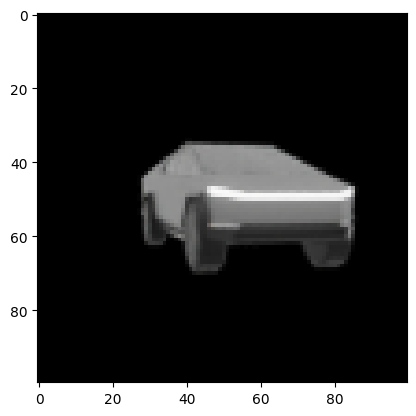

In [4]:
train_data = TinyCybertruckDataset()
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

testimg, testpose, testfocal = TinyCybertruckDataset(split='test')[0]
testpose = testpose.to(device)

plt.imshow(testimg)
plt.show()

In [5]:
model = TinyNerfModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

In [6]:
# Using Xavier initialization because model performs better (found out through trial and error)
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)

In [7]:
model = model.to(device)

Epoch 0


100%|██████████| 105/105 [00:13<00:00,  7.98it/s]


Epoch took 13.167433500289917 seconds, Loss: 0.010482147336006165


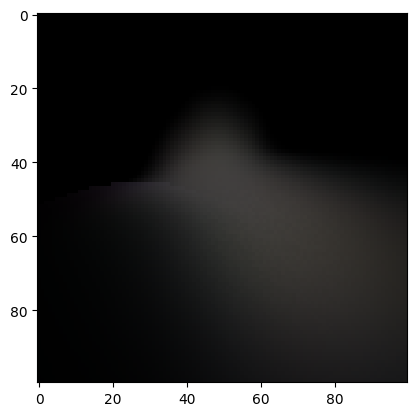

Epoch 1


100%|██████████| 105/105 [00:12<00:00,  8.37it/s]


Epoch took 12.551279306411743 seconds, Loss: 0.005547320935875177


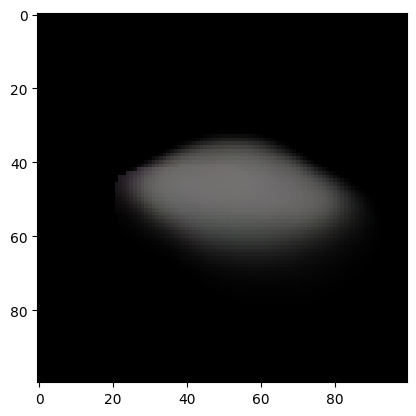

Epoch 2


100%|██████████| 105/105 [00:12<00:00,  8.42it/s]


Epoch took 12.475629806518555 seconds, Loss: 0.004298761952668428


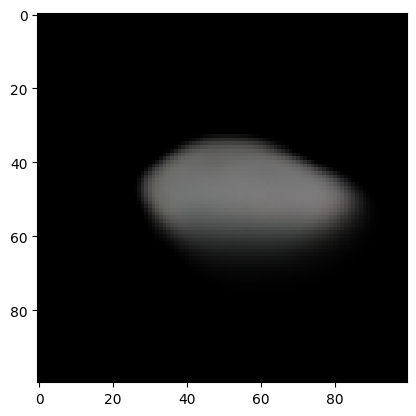

Epoch 3


100%|██████████| 105/105 [00:12<00:00,  8.29it/s]


Epoch took 12.66628623008728 seconds, Loss: 0.00757399620488286


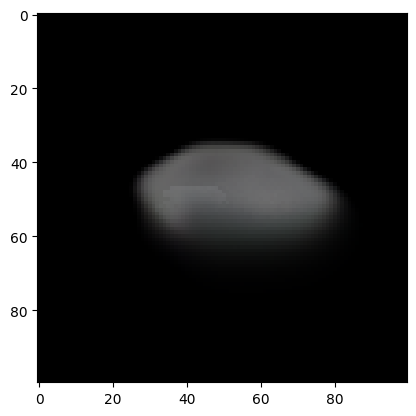

Epoch 4


100%|██████████| 105/105 [00:12<00:00,  8.23it/s]


Epoch took 12.75216031074524 seconds, Loss: 0.007876859046518803


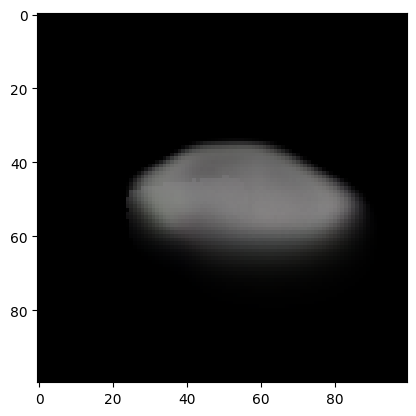

Epoch 5


100%|██████████| 105/105 [00:12<00:00,  8.33it/s]


Epoch took 12.599506378173828 seconds, Loss: 0.005980498157441616


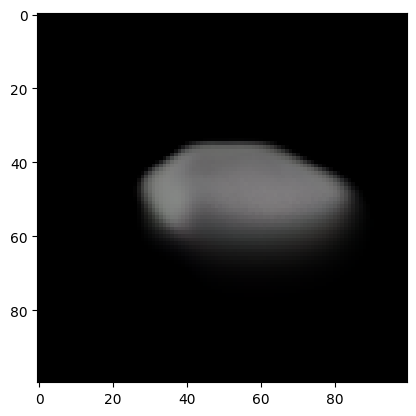

Epoch 6


100%|██████████| 105/105 [00:12<00:00,  8.44it/s]


Epoch took 12.446805238723755 seconds, Loss: 0.0041248733177781105


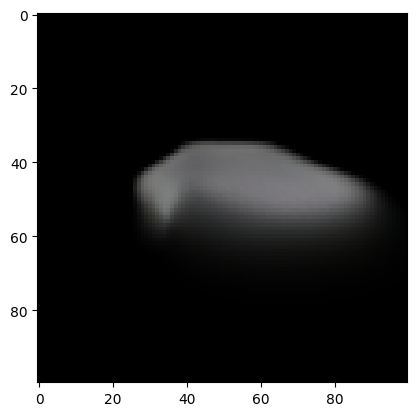

Epoch 7


100%|██████████| 105/105 [00:12<00:00,  8.43it/s]


Epoch took 12.450103044509888 seconds, Loss: 0.0037003071047365665


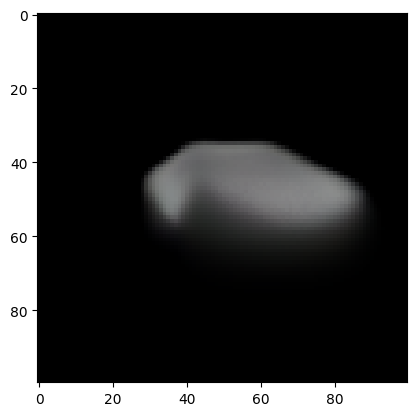

Epoch 8


100%|██████████| 105/105 [00:12<00:00,  8.43it/s]


Epoch took 12.454253911972046 seconds, Loss: 0.00476429658010602


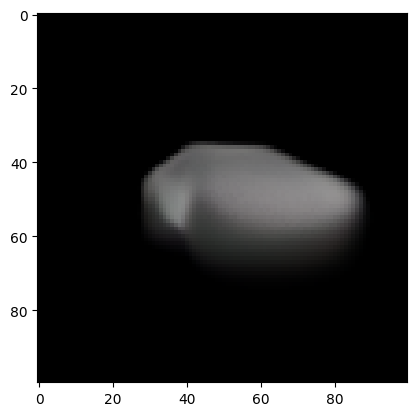

Epoch 9


100%|██████████| 105/105 [00:12<00:00,  8.43it/s]


Epoch took 12.45206332206726 seconds, Loss: 0.003037831047549844


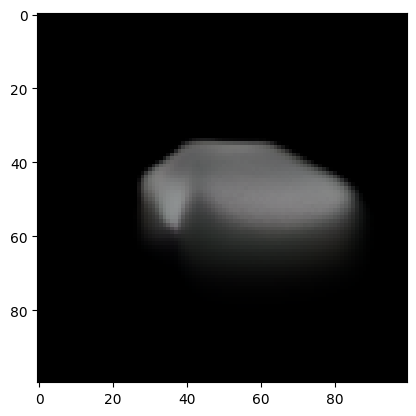

In [8]:
NUM_EPOCHS = 10
near, far = train_data.get_near_far()
H, W = train_data.get_image_size()
N_samples = 64


for i in range(NUM_EPOCHS):
    print(f"Epoch {i}")
    start_time = time.time()
    
    for target_image, pose, focal in tqdm(train_dataloader):
        target_image = target_image.to(device)
        pose = pose.squeeze().to(device)
        focal = focal.to(device)

        rays_o, rays_d = get_rays(H, W, focal, pose, device=device)
        rgb_map = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        
        loss = loss_fn(rgb_map, target_image.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch took {time.time() - start_time} seconds, Loss: {loss.item()}")
    with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, testfocal, testpose, device=device)
        rgb = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        plt.imshow(rgb.cpu().numpy())
        plt.show()

